In [4]:
import copy
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights, MaskRCNN_ResNet50_FPN_V2_Weights
from pathlib import Path

In [5]:
def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

def display_image(image):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    plt.show()

    
def display_image_pair(first_image, second_image):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)

    plt.show()

In [6]:
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

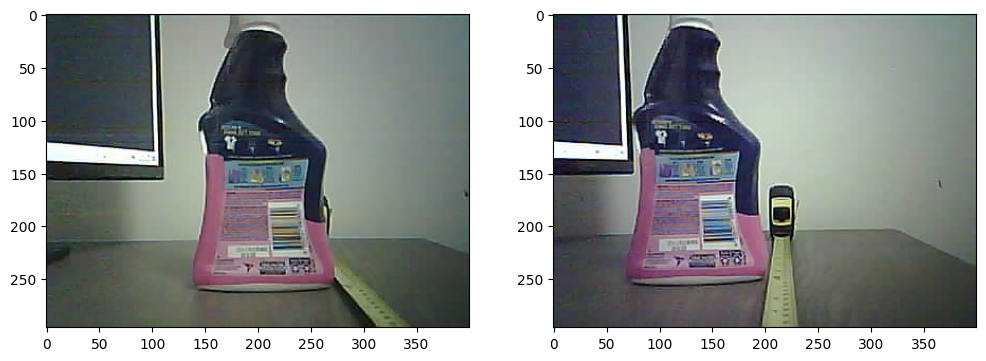

(296, 400, 3)


In [34]:
d_calib = "30cm"

left_eye = 'left_eye_30cm.jpg' 
right_eye = 'right_eye_30cm.jpg'

left_img = load_img(left_eye)

right_img = load_img(right_eye)

sz1 = right_img.shape[1]
sz2 = right_img.shape[0]

display_image_pair(left_img, right_img)

imgs = [left_img, right_img]

left_right = [preprocess_image(d).squeeze(dim=0) for d in imgs]

print(right_img.shape)

In [35]:

weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

In [36]:

def get_detections(maskrcnn, imgs, score_threshold=0.5): 
    ''' Runs maskrcnn over all frames in vid, storing the detections '''
    det = []
    lbls = []
    scores = []
    masks = []
    
    for img in imgs:
        with torch.no_grad():
            result = maskrcnn(preprocess_image(img))[0]
    
        mask = result["scores"] > score_threshold

        boxes = result["boxes"][mask].detach().cpu().numpy()
        det.append(boxes)
        lbls.append(result["labels"][mask].detach().cpu().numpy())
        scores.append(result["scores"][mask].detach().cpu().numpy())

        masks.append(result["masks"][mask]) 

    return det, lbls, scores, masks




In [37]:
det, lbls, scores, masks = get_detections(model,imgs)

In [38]:
print(np.array(weights.meta["categories"])[lbls[0]])
print(np.array(weights.meta["categories"])[lbls[1]])

['tv' 'bottle']
['tv' 'bottle' 'cell phone']


In [39]:

def draw_detections(img, det, colours=COLOURS, obj_order = None):
    for i, (tlx, tly, brx, bry) in enumerate(det):
        if obj_order is not None and len(obj_order) < i:
            i = obj_order[i]
        i %= len(colours)
        c = colours[i]
        
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)

def annotate_class(img, det, lbls, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'

        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


def draw_instance_segmentation_mask(img, masks):
    ''' Draws segmentation masks over an img '''
    seg_colours = np.zeros_like(img, dtype=np.uint8)
    for i, mask in enumerate(masks):
        col = (mask[0, :, :, None] * COLOURS[i])
        seg_colours = np.maximum(seg_colours, col.astype(np.uint8))
    cv2.addWeighted(img, 0.75, seg_colours, 0.75, 1.0, dst=img)    
    

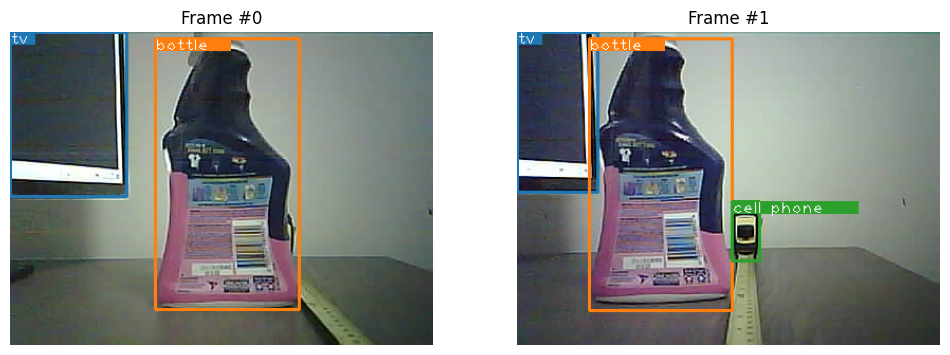

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masksi = masks[i].detach().cpu().numpy()
    annotate_class(img,deti,lbls[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

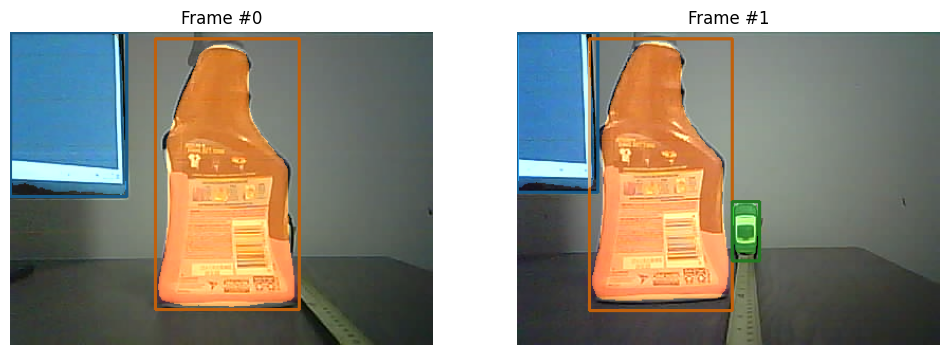

In [41]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masks[i][masks[i]<0.7]=0
    masksi = masks[i].detach().cpu().numpy()
    draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

In [42]:

def tlbr_to_center1(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append([cx, cy])
    return points

def tlbr_to_corner(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+tlx)/2
        cy = (tly+tly)/2
        points.append((cx, cy))
    return points

def tlbr_to_corner_br(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx+brx)/2
        cy = (bry+bry)/2
        points.append((cx, cy))
    return points

def tlbr_to_area(boxes):
    areas = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx-tlx)
        cy = (bry-tly)
        areas.append(abs(cx*cy))
    return areas


In [43]:
def get_horiz_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_tl(boxes):
    pnts1 = np.array(tlbr_to_corner(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_br(boxes):
    pnts1 = np.array(tlbr_to_corner_br(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner_br(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_vertic_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,1]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,1]
    return pnts1[:,None] - pnts2[None]

def get_area_diffs(boxes):
    pnts1 = np.array(tlbr_to_area(boxes[0]))
    pnts2 = np.array(tlbr_to_area(boxes[1]))
    return abs(pnts1[:,None] - pnts2[None])


In [44]:

centre = sz1/2

def get_dist_to_centre_tl(box, cntr = centre):
    pnts = np.array(tlbr_to_corner(box))[:,0]
    return abs(pnts - cntr)


def get_dist_to_centre_br(box, cntr = centre):
    pnts = np.array(tlbr_to_corner_br(box))[:,0]
    return abs(pnts - cntr)

In [45]:
tmp1 = get_dist_to_centre_br(det[0])
tmp2 = get_dist_to_centre_br(det[1])
print(tmp1)
print(tmp2)

[89.21508026 73.46057129]
[123.86347198   3.72593689  29.23742676]


In [46]:
def get_cost(boxes, lbls = None, sz1 = 400):
    alpha = sz1; beta  = 10; gamma = 5

    vert_dist = gamma*abs(get_vertic_dist_centre(boxes))

    horiz_dist = get_horiz_dist_centre(boxes)

    horiz_dist[horiz_dist<0] = beta*abs(horiz_dist[horiz_dist<0])

    area_diffs = get_area_diffs(boxes)/alpha
    
    cost = np.array([vert_dist,horiz_dist,area_diffs])
    
    cost=cost.sum(axis=0)

    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=150
    return cost
   

In [48]:
def get_cost_with_com(masks, lbls = None,prob_thresh = 0.7):
    alpha = 240; beta  = 10; gamma = 5

    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)

    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)

    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)

    cost = (left_params[:,None] - right_params[None])
    cost[:,:,2]=abs(cost[:,:,2])/alpha

    cost[cost[:,:,1]<0] = beta*abs(cost[cost[:,:,1]<0])

    cost[:,:,0] = gamma*abs(cost[:,:,0])
    cost = cost.sum(dim=2)
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=100
    return cost
   
    
def get_horiz_dist(masks, prob_thresh = 0.7):
    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)

    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)

    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)

    cost = (left_params[:,None] - right_params[None])
    return cost[:,:,1]


In [49]:
def get_tracks(cost):
    return scipy.optimize.linear_sum_assignment(cost)
    

def get_tracks_ij(cost):
    tracks = scipy.optimize.linear_sum_assignment(cost)
    return [[i,j] for i, j in zip(*tracks)]

In [50]:
cost = get_cost(det, lbls = lbls)

In [51]:
tracks = scipy.optimize.linear_sum_assignment(cost)
print(tracks)

h_d = [[np.array(weights.meta["categories"])[lbls[0]][i],np.array(weights.meta["categories"])[lbls[1]][j]] for i, j in zip(*tracks)]
print(np.array(weights.meta["categories"])[lbls[0]])
print(h_d)

(array([0, 1]), array([0, 1]))
['tv' 'bottle']
[['tv', 'tv'], ['bottle', 'bottle']]


In [52]:
dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)

final_dists = []
dctl = get_dist_to_centre_tl(det[0])
dcbr = get_dist_to_centre_br(det[0])

for i, j in zip(*tracks):
    if dctl[i] < dcbr[i]:
        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        
    else:
        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        

final_dists

[(34.64839172363281, 'tv'), (68.75157165527344, 'bottle')]

In [53]:
fl = 30-38.44*50/68.75
print(fl)

2.043636363636363


In [54]:
tantheta = (1/(50-fl))*(7.05/2)*sz1/38.44
print(tantheta)

0.7648732789907391


In [55]:
fd = [i for (i,j) in final_dists]
print(fd)

[34.64839172363281, 68.75157165527344]


In [56]:
dists_away = (7.05/2)*sz1*(1/tantheta)/np.array(fd)+fl

In [57]:
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][i]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][i]} is {dists_away[i]:.1f}cm away')

tv is 55.2cm away
bottle is 28.9cm away


In [58]:
def annotate_class2(img, det, lbls,class_map, conf=None,  colours=COLOURS):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[i]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'

        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


In [59]:
list(np.array(cat_dist)[(tracks[0])])

['tv 55.2cm', 'bottle 28.9cm']

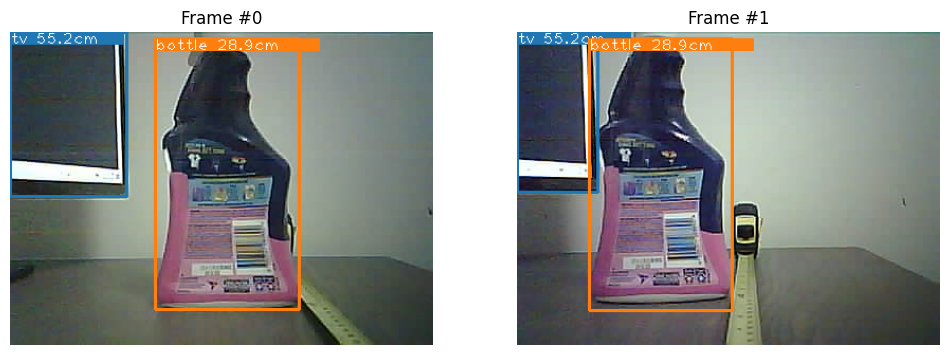

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

t1 = [list(tracks[1]), list(tracks[0])]

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[i]))
    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')
    